In [1]:
import torch

from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from collidium import *

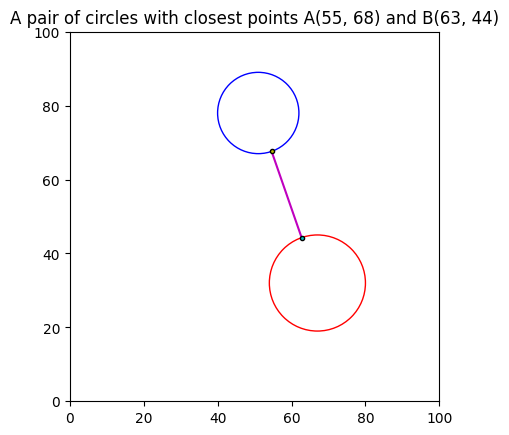

In [2]:
circles_closest_points_dataset_generator(8000, 0.5, 'train_closest_points.csv')
circles_closest_points_dataset_generator(2000, 0.5, 'test_closest_points.csv')
closest_points_random_figure_generator('train_closest_points.csv')

In [3]:
training_data = ClosestPointsDataset('train_closest_points.csv')
test_data = ClosestPointsDataset('test_closest_points.csv')
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [4]:
learning_rate = 1e-3
weight_decay = 1e-5
batch_size = 64
epochs = 10
model = ShallowNetClosestPoints(input_size=6, hidden_size=32, output_size=4).to(device)
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss, total_mae = 0, 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        y_hat = model(X)

        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        total_mae += torch.abs(y_hat - y).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_mae = total_mae / len(dataloader.dataset)

    print(f"Train Error: \n MAE: {avg_mae:.2g}, Avg loss: {avg_loss:.2g} \n")

    return avg_loss, avg_mae

def test_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss, total_mae = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)

            loss = loss_fn(y_hat, y)
            total_loss += loss.item() * X.size(0)
            total_mae += torch.abs(y_hat - y).sum().item()

        avg_loss = total_loss / len(dataloader.dataset)
        avg_mae = total_mae / len(dataloader.dataset)

    print(f"Test Error: \n MAE: {avg_mae:.2g}, Avg loss: {avg_loss:.2g} \n")

    return avg_loss, avg_mae

Train Error: 
 MAE: 98, Avg loss: 9.8e+02 

Test Error: 
 MAE: 56, Avg loss: 3e+02 

Train Error: 
 MAE: 41, Avg loss: 1.8e+02 

Test Error: 
 MAE: 32, Avg loss: 1.1e+02 

Train Error: 
 MAE: 29, Avg loss: 94 

Test Error: 
 MAE: 28, Avg loss: 88 

Train Error: 
 MAE: 27, Avg loss: 81 

Test Error: 
 MAE: 27, Avg loss: 82 

Train Error: 
 MAE: 26, Avg loss: 77 

Test Error: 
 MAE: 26, Avg loss: 79 

Train Error: 
 MAE: 24, Avg loss: 72 

Test Error: 
 MAE: 24, Avg loss: 71 

Train Error: 
 MAE: 23, Avg loss: 65 

Test Error: 
 MAE: 23, Avg loss: 65 

Train Error: 
 MAE: 22, Avg loss: 61 

Test Error: 
 MAE: 22, Avg loss: 62 

Train Error: 
 MAE: 22, Avg loss: 58 

Test Error: 
 MAE: 22, Avg loss: 59 

Train Error: 
 MAE: 21, Avg loss: 56 

Test Error: 
 MAE: 22, Avg loss: 58 



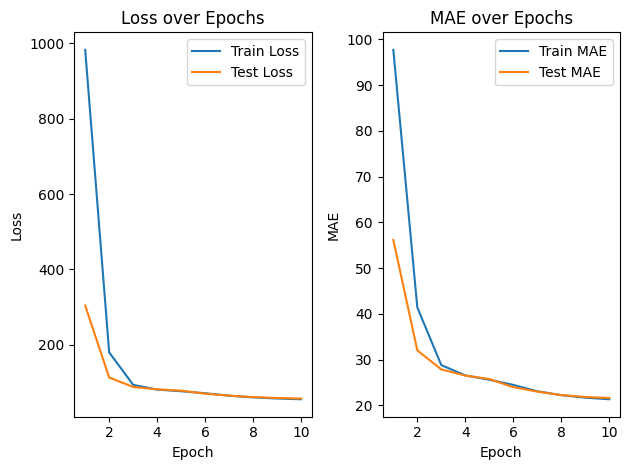

In [6]:
train_loss = []
train_mae = []
test_loss = []
test_mae = []
epochs_range = range(1, epochs + 1)

for epoch in epochs_range:
    epoch_train_loss, epoch_train_mae = train_loop(train_dataloader, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_mae = test_loop(test_dataloader, model, loss_fn)
    train_loss.append(epoch_train_loss)
    train_mae.append(epoch_train_mae)
    test_loss.append(epoch_test_loss)
    test_mae.append(epoch_test_mae)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_mae, label='Train MAE')
plt.plot(epochs_range, test_mae, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig('interpenetration_distances_train_test_plot.png')

In [7]:
torch.save(model, 'closest_points_model.pth')